In [22]:
!pip install tensorflow
!pip install opencv-python opencv-python-headless opencv-contrib-python

In [23]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [25]:
train_dir = os.path.join(path, "Train")
test_dir = os.path.join(path, "Test")

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]
num_classes = len(classes)

In [26]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

img_width, img_height = 100, 100

def balance_dataset(directory, classes, max_samples_per_class=7140):
    X, y = [], []
    class_to_label = {class_name: i for i, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue

        image_files = os.listdir(class_dir)[:max_samples_per_class]

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (img_width, img_height))
                image = image / 255.0
                X.append(image)
                y.append(class_to_label[class_name])

    return np.array(X), np.array(y)

X_train, y_train = balance_dataset(train_dir, classes)
X_test, y_test = balance_dataset(test_dir, classes)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=35)

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

input_layer = Input(shape=(img_width, img_height, 3))

x = Conv2D(3, (3, 3), padding="same", activation="relu")(input_layer)

base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer = Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 4, 4, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,013,705 (3.87 MB)

 Trainable params: 74,585 (291.35 KB)

 Non-trainable params: 939,120 (3.58 MB)

None


In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 95s 45ms/step - accuracy: 0.3088 - loss: 1.5398 - val_accuracy: 0.5826 - val_loss: 1.0705
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.5667 - loss: 1.1101 - val_accuracy: 0.7269 - val_loss: 0.7963
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.6495 - loss: 0.9389 - val_accuracy: 0.7657 - val_loss: 0.7058
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.6989 - loss: 0.8241 - val_accuracy: 0.7993 - val_loss: 0.5777
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.7351 - loss: 0.7242 - val_accuracy: 0.8508 - val_loss: 0.4676
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 72s 40ms/step - accuracy: 0.7632 - loss: 0.6525 - val_accuracy: 0.8706 - val_loss: 0.4188
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.7868 - loss: 0.5964 - val_accuracy: 0.8763 - val_loss: 0.3791
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.8027 - loss: 0.55

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9558 - loss: 0.1371
Train Accuracy: 90.23%
Test Accuracy: 95.52%


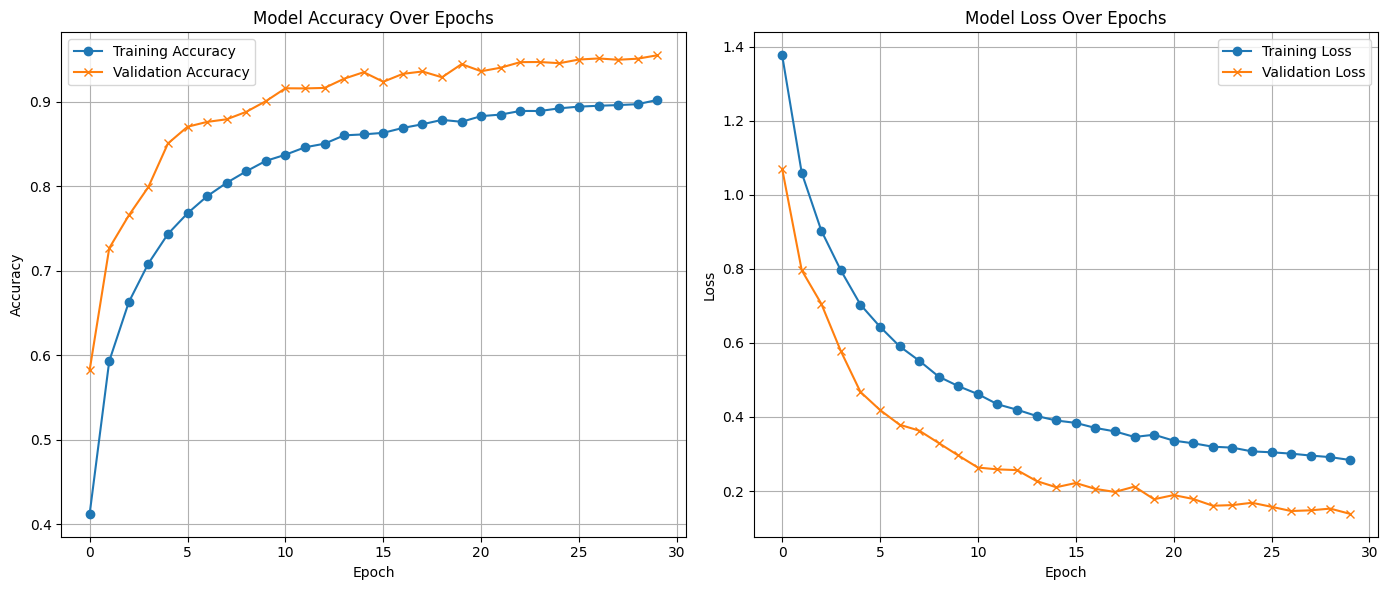

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step


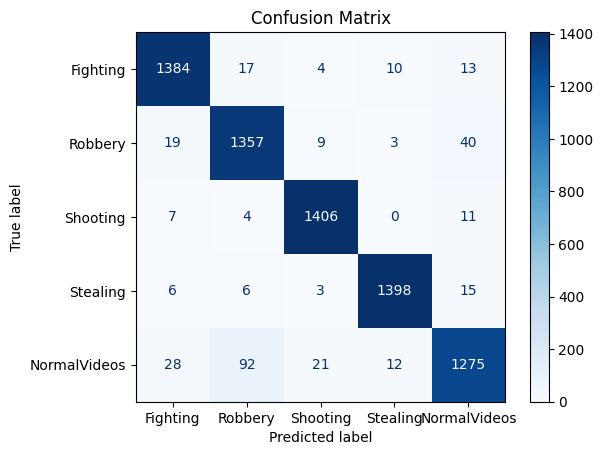

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

predicted crime is :10: Robbery
predicted crime is: 10: Robbery


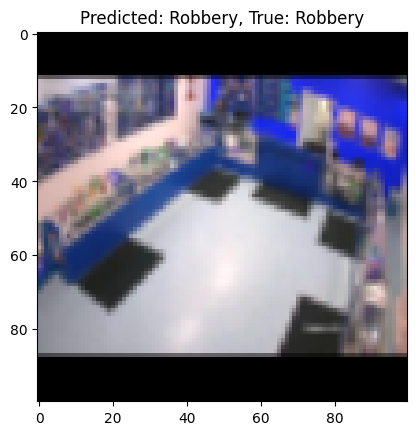

In [ ]:
image_index = 10
predicted_label = classes[y_pred[image_index]]
true_label = classes[y_test[image_index]]

print(f"predicted crime is :{image_index}: {predicted_label}")
print(f"predicted crime is: {image_index}: {true_label}")

plt.imshow(X_test[image_index])  # عرض الصورة
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


### منقلل من ال data augmentation


In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

input_layer = Input(shape=(img_width, img_height, 3))

x = Conv2D(3, (3, 3), padding="same", activation="relu")(input_layer)

base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=16)

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 4, 4, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,705 (3.87 MB)

 Trainable params: 74,585 (291.35 KB)

 Non-trainable params: 939,120 (3.58 MB)

None


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 136s 73ms/step - accuracy: 0.2672 - loss: 1.5816 - val_accuracy: 0.5735 - val_loss: 1.1275
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 129s 72ms/step - accuracy: 0.5375 - loss: 1.1628 - val_accuracy: 0.6894 - val_loss: 0.8833
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 129s 72ms/step - accuracy: 0.6316 - loss: 0.9811 - val_accuracy: 0.7454 - val_loss: 0.7654
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 127s 71ms/step - accuracy: 0.6888 - loss: 0.8420 - val_accuracy: 0.7863 - val_loss: 0.6403
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 127s 71ms/step - accuracy: 0.7189 - loss: 0.7606 - val_accuracy: 0.8221 - val_loss: 0.5309
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 128s 72ms/step - accuracy: 0.7459 - loss: 0.6922 - val_accuracy: 0.8500 - val_loss: 0.4753
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 128s 72ms/step - accuracy: 0.7641 - loss: 0.6492 - val_accuracy: 0.8641 - val_loss: 0.4298
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 128s 72ms/step - accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9475 - loss: 0.1716
Train Accuracy: 88.61%
Test Accuracy: 94.64%


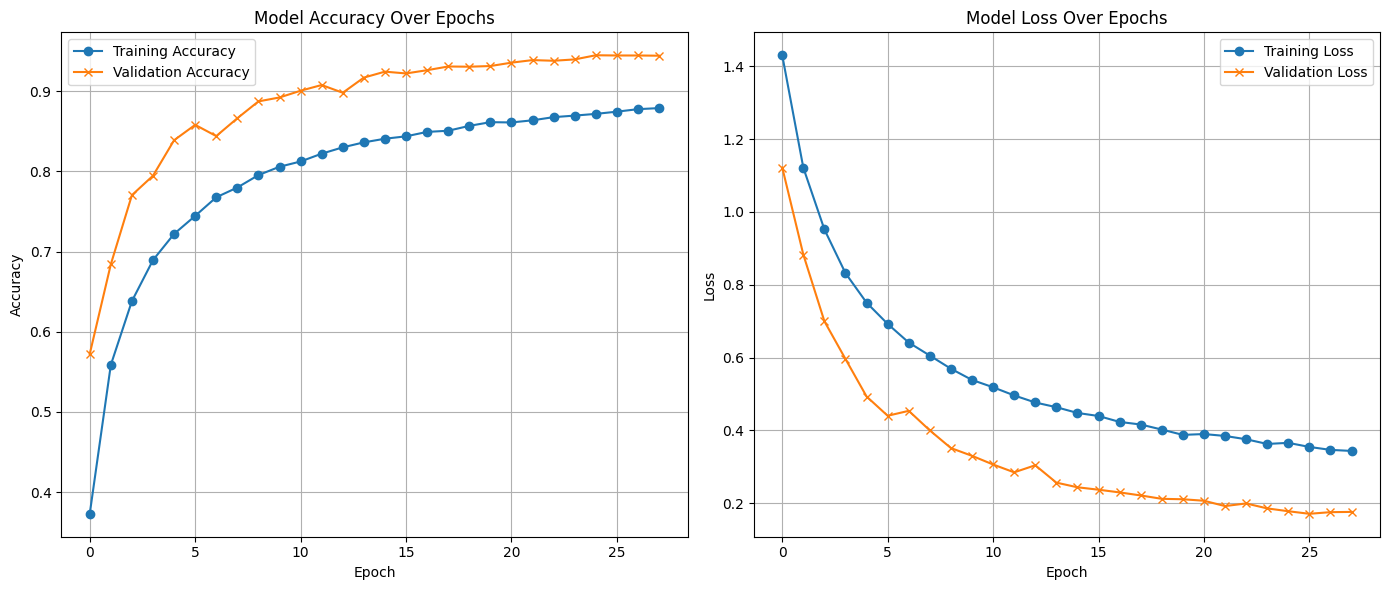

224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step


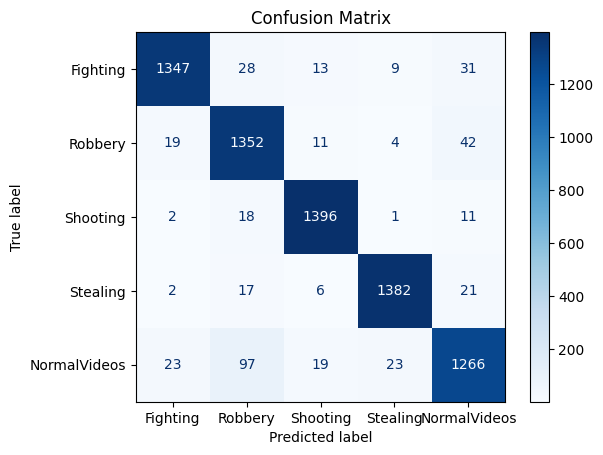

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

predicted crime is :28: Stealing
predicted crime is: 28: Stealing


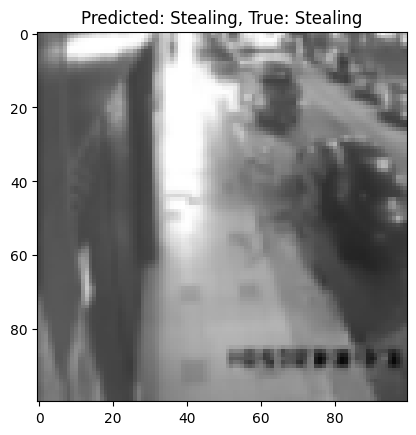

In [ ]:
image_index = 28
predicted_label = classes[y_pred[image_index]]
true_label = classes[y_test[image_index]]

print(f"predicted crime is :{image_index}: {predicted_label}")
print(f"predicted crime is: {image_index}: {true_label}")

plt.imshow(X_test[image_index])
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


### فك تجميد اخر طبقتين فقط للتجربة

In [27]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout

input_layer = Input(shape=(img_width, img_height, 3))

x = Conv2D(3, (3, 3), padding="same", activation="relu")(input_layer)

base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
x = base_model(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-5:]:
    layer.trainable = True



/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [28]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=16)

In [29]:
model.compile(optimizer = Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 4, 4, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,705 (3.87 MB)

 Trainable params: 131,225 (512.60 KB)

 Non-trainable params: 882,480 (3.37 MB)

None


In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 140s 75ms/step - accuracy: 0.4404 - loss: 1.3423 - val_accuracy: 0.5368 - val_loss: 1.1771
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 132s 74ms/step - accuracy: 0.7259 - loss: 0.7483 - val_accuracy: 0.8394 - val_loss: 0.4934
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 131s 74ms/step - accuracy: 0.8050 - loss: 0.5459 - val_accuracy: 0.9112 - val_loss: 0.2842
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 133s 74ms/step - accuracy: 0.8364 - loss: 0.4580 - val_accuracy: 0.9185 - val_loss: 0.2460
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 131s 74ms/step - accuracy: 0.8644 - loss: 0.3894 - val_accuracy: 0.9352 - val_loss: 0.1912
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 132s 74ms/step - accuracy: 0.8804 - loss: 0.3438 - val_accuracy: 0.9473 - val_loss: 0.1567
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 131s 73ms/step - accuracy: 0.8935 - loss: 0.3083 - val_accuracy: 0.9490 - val_loss: 0.1601
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 132s 74ms/step - accuracy: 0.9049 - lo

In [31]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9821 - loss: 0.0560
Train Accuracy: 96.81%
Test Accuracy: 98.19%


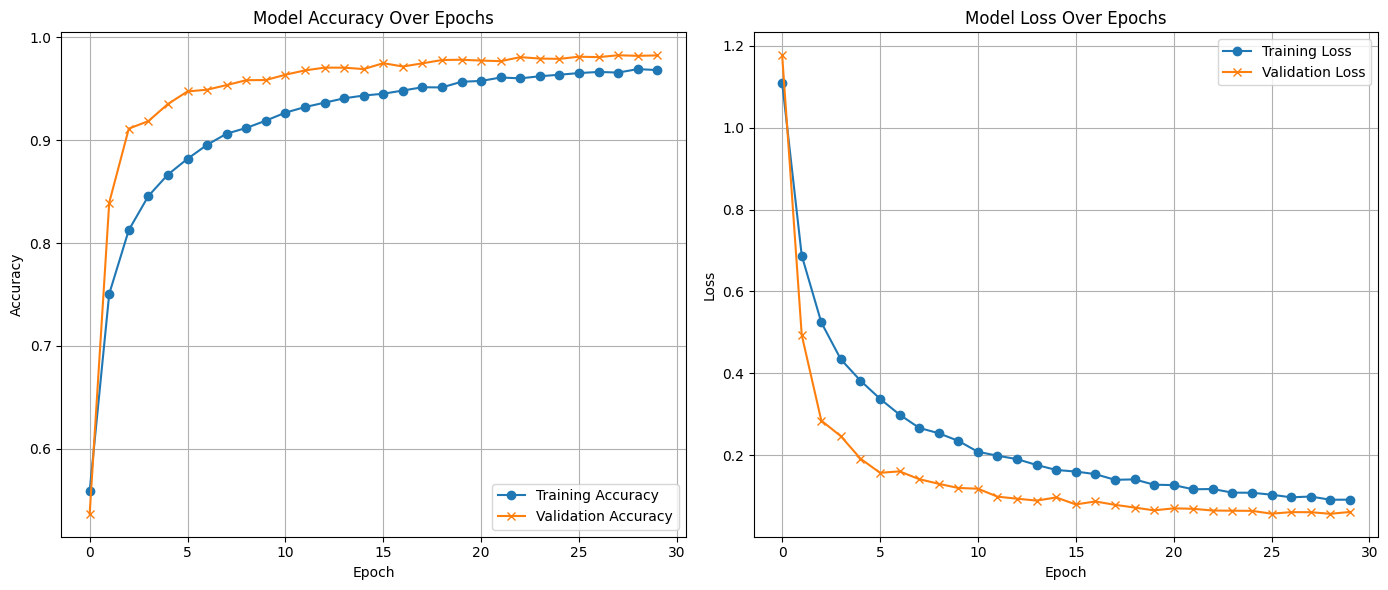

224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step


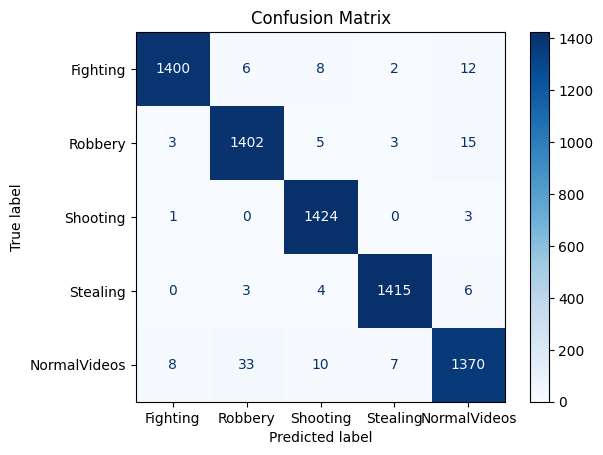

In [32]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

predicted crime is :28: Stealing
predicted crime is: 28: Stealing


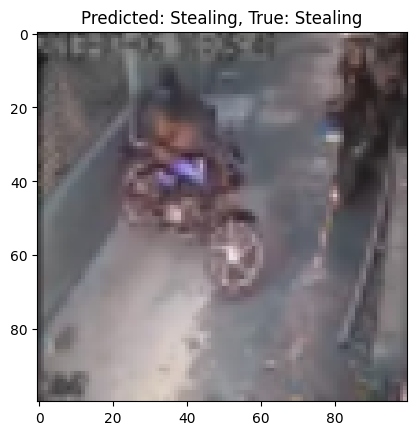

In [33]:
image_index = 28
predicted_label = classes[y_pred[image_index]]
true_label = classes[y_test[image_index]]

print(f"predicted crime is :{image_index}: {predicted_label}")
print(f"predicted crime is: {image_index}: {true_label}")

plt.imshow(X_test[image_index])
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


In [34]:
model.save("mobileNetV3small.keras")